In [1]:
from bs4 import BeautifulSoup
import pickle
import re
import random
import requests
import itertools
import openai
import networkx
import matplotlib.pyplot as plt


from knowledge_component import KC, ContentExample

In [2]:
def get_key_terms(chapter):
    kt_url = f"https://openstax.org/books/introduction-sociology-3e/pages/{chapter}-key-terms"
    page = requests.get(kt_url)
    soup = BeautifulSoup(page.content, "html.parser")

    terms = []
    #the strict order of the webpage helps us here- each term is a '<dl> <dt> </dt> <dd> </dd> </dl>'
    for term in soup.find(id="main-content").find_all("dl"):
        term_title = term.find("dt").get_text()
        term_text = term.find("dd").get_text()
        terms.append(KC(str(chapter), term_title, term_text) )

    return terms

In [3]:
#badda bing badda boom baby
all_terms = []
_ = [all_terms.extend(get_key_terms(i)) for i in range(1,21)]
len(all_terms)

503

In [4]:
#Ok, so, now the next step is to see about just grabbing all of the text content for a page in a useful way.
#I had discussed making "knowledge components" out of sub-headers also, how feasable is that?

def get_chapter_text(chapter_slug):
    textbook_url = f"https://openstax.org/books/introduction-sociology-3e/pages/{chapter_slug}"
    page = requests.get(textbook_url)
    soup = BeautifulSoup(page.content, "html.parser")

    content = soup.find(id="main-content")
    if content is None:
        return None, None
        
    
    #Every chapter starts with a "learning objectives" section that I'll extract separately
    learning_objectives = [l.get_text() for l in content.find_all("section")[0].find_all("li")]
    
    chapter_text = []
    #So the question is how to get just the most child sections, to prevent big duplications
    for section in content.find_all("section")[1:]:
        if len(section.find_all("section")) == 0:
            text = re.sub("[\n]+", "  ", section.get_text())
           
            
            chapter_text.append(ContentExample(chapter_slug, text))


    return learning_objectives, chapter_text


li, text = get_chapter_text("21-1-collective-behavior")

In [5]:
#Extracting the chapter titles we want from the "ol" item on the page- the navigation sidebar. 
textbook_url = f"https://openstax.org/books/introduction-sociology-3e/pages/1-introduction"
page = requests.get(textbook_url)
soup = BeautifulSoup(page.content, "html.parser")


all_chapter_titles = [i.get_text() for i in soup.find("ol").find_all("li")]
valid_chapters = [i for i in all_chapter_titles if re.match("\d[.\d]* [\w| ?]+", i)]
chapter_slugs = [re.sub("[\W]+", "-", i.lower()) for i in valid_chapters]
chapter_slugs = [c[:-1] if c.endswith("-") else c for c in chapter_slugs ]

print(chapter_slugs)

['1-1-what-is-sociology', '1-2-the-history-of-sociology', '1-3-theoretical-perspectives-in-sociology', '1-4-why-study-sociology', '2-1-approaches-to-sociological-research', '2-2-research-methods', '2-3-ethical-concerns', '3-1-what-is-culture', '3-2-elements-of-culture', '3-3-high-low-pop-sub-counter-culture-and-cultural-change', '3-4-theoretical-perspectives-on-culture', '4-1-types-of-societies', '4-2-theoretical-perspectives-on-society', '4-3-social-constructions-of-reality', '5-1-theories-of-self-development', '5-2-why-socialization-matters', '5-3-agents-of-socialization', '5-4-socialization-across-the-life-course', '6-1-types-of-groups', '6-2-group-size-and-structure', '6-3-formal-organizations', '7-1-deviance-and-control', '7-2-theoretical-perspectives-on-deviance-and-crime', '7-3-crime-and-the-law', '8-1-technology-today', '8-2-media-and-technology-in-society', '8-3-global-implications-of-media-and-technology', '8-4-theoretical-perspectives-on-media-and-technology', '9-1-what-is-s

In [6]:
los = []
texts = []

for slug in chapter_slugs:
    lo, text = get_chapter_text(slug)
    if lo is not None:
        los.extend(lo)
        texts.extend(text)
        print(f"got {slug} ")
    else:
        print(f"{slug} is None?")

print(f"Ultimately got {len(los)} learning objectves")


got 1-1-what-is-sociology 
got 1-2-the-history-of-sociology 
got 1-3-theoretical-perspectives-in-sociology 
got 1-4-why-study-sociology 
got 2-1-approaches-to-sociological-research 
got 2-2-research-methods 
got 2-3-ethical-concerns 
got 3-1-what-is-culture 
got 3-2-elements-of-culture 
got 3-3-high-low-pop-sub-counter-culture-and-cultural-change 
got 3-4-theoretical-perspectives-on-culture 
got 4-1-types-of-societies 
got 4-2-theoretical-perspectives-on-society 
got 4-3-social-constructions-of-reality 
got 5-1-theories-of-self-development 
got 5-2-why-socialization-matters 
got 5-3-agents-of-socialization 
got 5-4-socialization-across-the-life-course 
got 6-1-types-of-groups 
got 6-2-group-size-and-structure 
got 6-3-formal-organizations 
got 7-1-deviance-and-control 
got 7-2-theoretical-perspectives-on-deviance-and-crime 
got 7-3-crime-and-the-law 
got 8-1-technology-today 
got 8-2-media-and-technology-in-society 
got 8-3-global-implications-of-media-and-technology 
got 8-4-theoretic

In [7]:
##Adding in the chapter context to each term

for term in all_terms:
    term.context = [t for t in texts if term.title in t]


In [8]:
#KG structure for recomendation

#terms within a chapter are a fully connected subgraph
#each chapter 'introduction' is connected in a line to each other introduction
#each chapter summary is connected to all of the next chapters terms
#each term has an edge to every chapter that it appears in

#so we need to finish adding the introduction and summary subchapters
#then we can compile the graph!

# Question- what about the explicitly identified learning objectives?

In [9]:
import networkx as nx
from itertools import pairwise

KG = nx.Graph()
chapters = []
for term in all_terms:
    KG.add_node(term)
    chapter = f"chapter {term.chapter}"
    KG.add_edge(term, chapter)
    chapters.append(chapter)
    
    #This step makes the graph much more jumbled. 
    if len(term.context) > 0:
        for context in term.context:
            for other_term in all_terms:
                if other_term.title in context and other_term != term:
                    KG.add_edge(term, other_term)
            
    
chapters = list(set(chapters))
for chapter in pairwise(chapters):
    KG.add_edge(chapter[0], chapter[1])



options = {
    'node_size': 50,
}

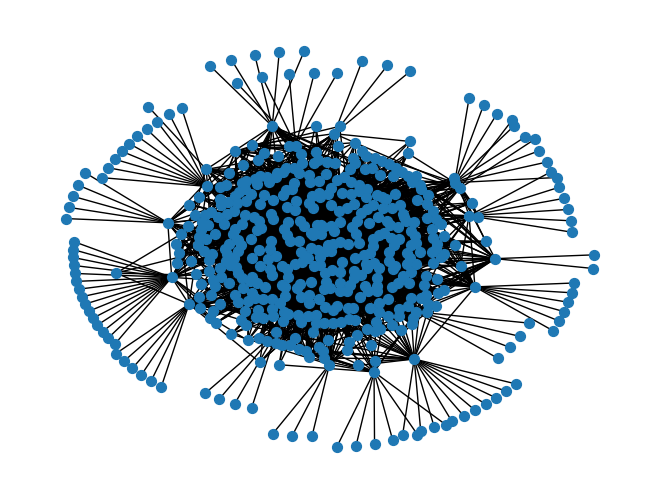

In [10]:
nx.draw_kamada_kawai(KG, **options)

In [11]:
#OK cool how to navigate? 
print(random.choice(list(KG["chapter 1"])))
print(random.choice(list(KG["chapter 2"])))
print(random.choice(list(KG["chapter 20"])))

dynamic equilibrium : a stable state in wh...
field research : gathering data from ...
demography : the study of populat...


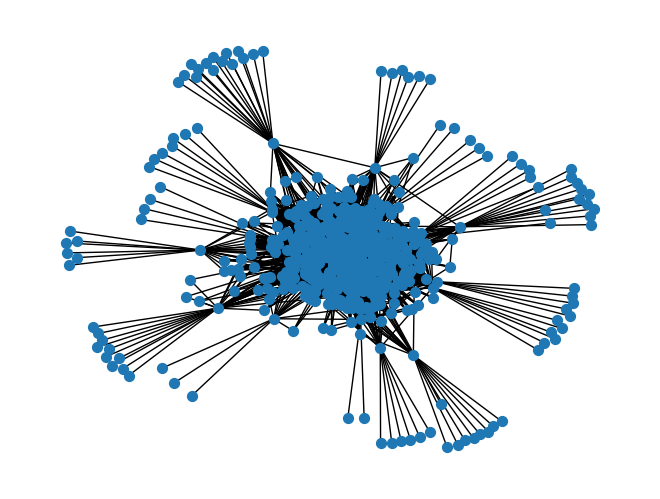

In [12]:
nx.draw(KG, **options)

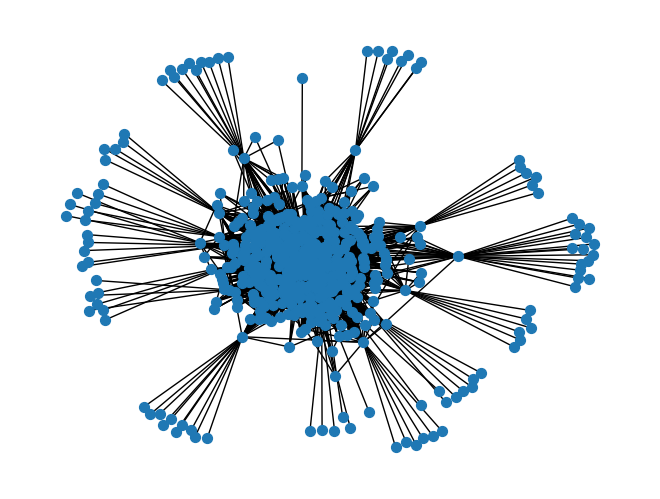

In [13]:
nx.draw_spring(KG, **options)

In [14]:
pickle.dump(KG, open("sociology_kg.pickle", "wb"))

In [15]:
#Some demo recommendation business:
random.sample(list(KG["chapter 1"]),3)

[generalized others : the organized and ge...,
 micro-level theories : the study of specifi...,
 latent functions : the unrecognized or ...]

In [16]:
term = random.choice(list(KG["chapter 1"]))
print(term)
random.sample(list(KG[term]), 3)

positivism : the scientific study...


[education : a social institution...,
 group : any collection of at...,
 society :  people who live in ...]

In [17]:
[i for i in KG["chapter 1"] if type(i)!= str]

[antipositivism : the view that social...,
 conflict theory : a theory that looks ...,
 constructivism : an extension of symb...,
 culture : a group's shared pra...,
 dramaturgical analysis : a technique sociolog...,
 dynamic equilibrium : a stable state in wh...,
 dysfunctions : social patterns that...,
 figuration : the process of simul...,
 function : the part a recurrent...,
 functionalism : a theoretical approa...,
 generalized others : the organized and ge...,
 grand theories : an attempt to explai...,
 hypothesis : a testable propositi...,
 latent functions : the unrecognized or ...,
 macro-level : a wide-scale view of...,
 manifest functions : sought consequences ...,
 micro-level theories : the study of specifi...,
 paradigms : philosophical and th...,
 positivism : the scientific study...,
 qualitative sociology : in-depth interviews,...,
 quantitative sociology : statistical methods ...,
 reification : an error of treating...,
 significant others : specific individuals...,
 